In [1]:
# read data
data = read.csv("prlmis-data-full.csv", header=TRUE, fileEncoding="UTF-8-BOM")

library(dplyr)

# remove alternate response variables
data = select(data, -c("PRLANY","PRLMISAB"))

# update categorical values from raw dataset to be descriptive
data$YEAR <- replace(data$YEAR, data$YEAR=="15", "2015")
data$YEAR <- replace(data$YEAR, data$YEAR=="16", "2016")
data$YEAR <- replace(data$YEAR, data$YEAR=="17", "2017")

data$AGECAT <- replace(data$AGECAT, data$AGECAT=="1", "12-17")
data$AGECAT <- replace(data$AGECAT, data$AGECAT=="2", "18-25")
data$AGECAT <- replace(data$AGECAT, data$AGECAT=="3", "26-35")
data$AGECAT <- replace(data$AGECAT, data$AGECAT=="4", "36-49")
data$AGECAT <- replace(data$AGECAT, data$AGECAT=="5", "50+")

data$SEX <- replace(data$SEX, data$SEX=="0", "Male")
data$SEX <- replace(data$SEX, data$SEX=="1", "Female")

data$MARRIED <- replace(data$MARRIED, data$MARRIED=="0", "Unmarried")
data$MARRIED <- replace(data$MARRIED, data$MARRIED=="1", "Divorced")
data$MARRIED <- replace(data$MARRIED, data$MARRIED=="2", "Widowed")
data$MARRIED <- replace(data$MARRIED, data$MARRIED=="3", "Married")
data$MARRIED <- replace(data$MARRIED, data$MARRIED=="4", "Married")

data$EDUCAT <- replace(data$EDUCAT, data$EDUCAT=="1", "School Age")
data$EDUCAT <- replace(data$EDUCAT, data$EDUCAT=="2", "Some HS")
data$EDUCAT <- replace(data$EDUCAT, data$EDUCAT=="3", "HS grad")
data$EDUCAT <- replace(data$EDUCAT, data$EDUCAT=="4", "Some College")
data$EDUCAT <- replace(data$EDUCAT, data$EDUCAT=="5", "College Grad")

data$EMPLOY18 <- replace(data$EMPLOY18, data$EMPLOY18=="0", "Unemployed")
data$EMPLOY18 <- replace(data$EMPLOY18, data$EMPLOY18=="1", "Part-Time")
data$EMPLOY18 <- replace(data$EMPLOY18, data$EMPLOY18=="2", "Full-Time")

# wrong
data$CTYMETRO <- replace(data$CTYMETRO, data$CTYMETRO=="1", "Rural")
data$CTYMETRO <- replace(data$CTYMETRO, data$CTYMETRO=="2", "Small")
data$CTYMETRO <- replace(data$CTYMETRO, data$CTYMETRO=="3", "Large")
data$CTYMETRO <- replace(data$CTYMETRO, data$CTYMETRO=="0", "na")

# convert categorical variables to factors
data$YEAR<-as.factor(data$YEAR)
data$AGECAT<-as.factor(data$AGECAT)
data$SEX<-as.factor(data$SEX)
data$MARRIED<-as.factor(data$MARRIED)
data$EDUCAT<-as.factor(data$EDUCAT)
data$EMPLOY18<-as.factor(data$EMPLOY18)
data$CTYMETRO<-as.factor(data$CTYMETRO)
#data$PRLMISEVR<-as.factor(data$PRLMISEVR)
data$HEROINEVR<-as.factor(data$HEROINEVR)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [83]:
# train/test split
set.seed(123)

fractrain = 0.75
fractest = 1-fractrain
flag <- sort(sample(dim(data)[1], dim(data)[1]*fractest, replace = FALSE))
train <- data[-flag,]
test <- data[flag,]
dim(train)
dim(test)

[1] 127738     19

[1] 42579    19

In [5]:
# create gbm model
library(gbm)

In [84]:
# build default gbm model
gbm1 <- gbm(PRLMISEVR ~ ., data=train, distribution = 'bernoulli',
            n.trees=2000,
            cv.folds = 3)

,var,rel.inf
HALUCNG,HALUCNG,34.5456993
COCAINE,COCAINE,17.2879423
AMPHETMN,AMPHETMN,12.0156335
TRQLZRS,TRQLZRS,10.0844533
MENTHLTH,MENTHLTH,7.2147968
HEROINUSE,HEROINUSE,4.1226177
TRTMENT,TRTMENT,3.5967053
HEROINEVR,HEROINEVR,3.5230155
SEDATVS,SEDATVS,2.2112590
AGECAT,AGECAT,1.8794893


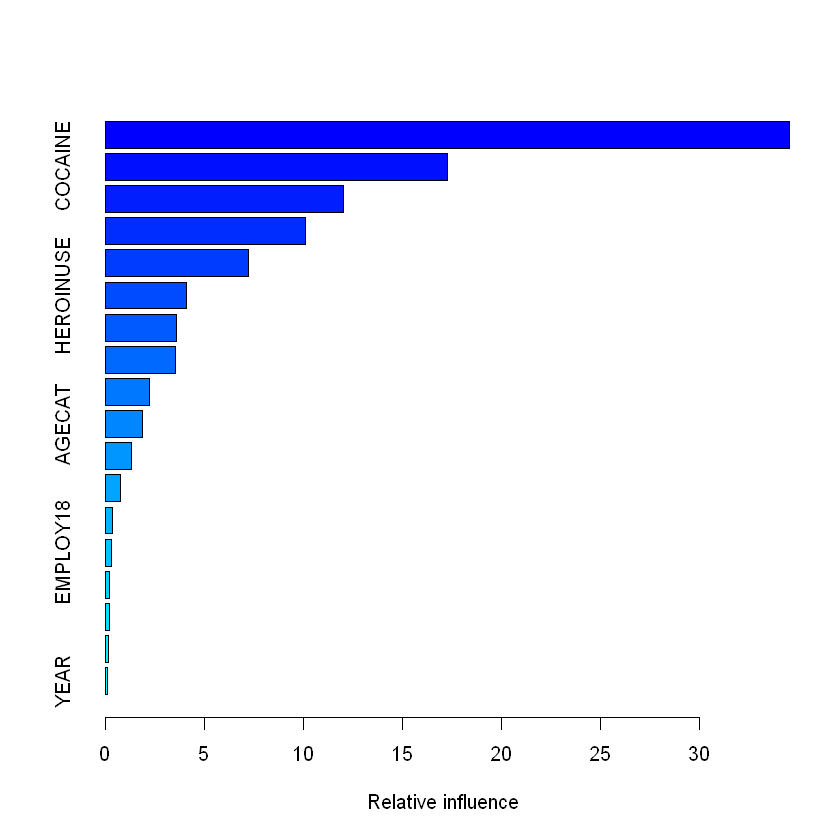

In [105]:
# divide plot area
par(mfrow =c(1,1))
summary(gbm1)

In [86]:
# get model predictions
pred.gbm1 <- predict(gbm1, test, n.trees=2000, type="response")
pred.gbm1 <- replace(pred.gbm1, pred.gbm1>=0.5, 1)
pred.gbm1 <- replace(pred.gbm1, pred.gbm1<0.5, 0)

# output confusion matrix and error rate for gbm1
pred.gbm1 <- as.factor(pred.gbm1)
test$PRLMISEVR <- as.factor(test$PRLMISEVR)

library(caret)
confusionMatrix(pred.gbm1, test$PRLMISEVR)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 37435  3415
         1   614  1115
                                          
               Accuracy : 0.9054          
                 95% CI : (0.9026, 0.9081)
    No Information Rate : 0.8936          
    P-Value [Acc > NIR] : 6.296e-16       
                                          
                  Kappa : 0.3161          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9839          
            Specificity : 0.2461          
         Pos Pred Value : 0.9164          
         Neg Pred Value : 0.6449          
             Prevalence : 0.8936          
         Detection Rate : 0.8792          
   Detection Prevalence : 0.9594          
      Balanced Accuracy : 0.6150          
                                          
       'Positive' Class : 0               
                  

[1] 1743

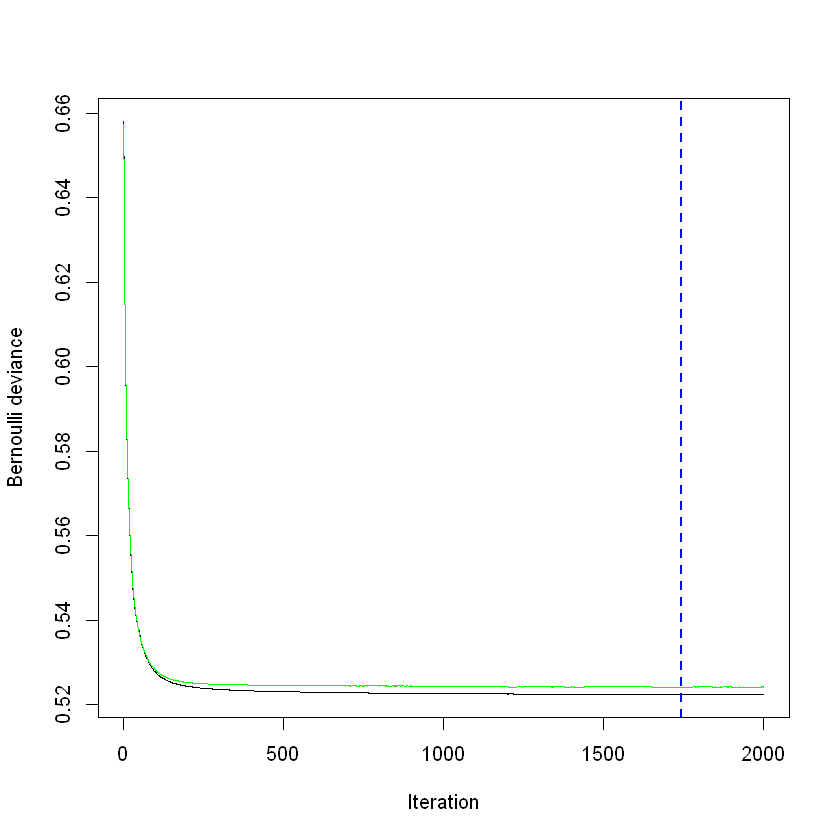

In [87]:
# plot loss
gbm.perf(gbm1, method = "cv")

In [88]:
# build default gbm model
gbm1 <- gbm(PRLMISEVR ~ ., data=train, distribution = 'bernoulli',
            n.trees=2000,
            cv.folds = 3)

# find best number of trees
best.ntrees <- which.min(gbm1$cv.error)
best.ntrees

[1] 1743

In [89]:
# build default gbm model
gbm1 <- gbm(PRLMISEVR ~ ., data=train, distribution = 'bernoulli',
            n.trees=2000,
            cv.folds = 3)

# create parameter grid to find best shrinkage and interaction depth
hyper_grid <- expand.grid(
  shrinkage = c(.05, .1, .2),
  interaction.depth = c(1, 3, 5),
  optimal_trees = 0,               
  min_loss = 0                     
)

# grid search 
for(i in 1:nrow(hyper_grid)) {
    set.seed(123)
    
    # train model
    gbm.tune <- gbm(PRLMISEVR ~ ., data=train,
                    distribution = "bernoulli",
                    n.trees = 2000,
                    shrinkage = hyper_grid$shrinkage[i],
                    interaction.depth = hyper_grid$interaction.depth[i],
                    train.fraction = .75,
                    cv.folds=2,
                    n.cores = NULL, # will use all cores by default
                    verbose = FALSE
                   )
    
    # add min training error and trees to grid
    hyper_grid$optimal_trees[i] <- which.min(gbm.tune$cv.error)
    hyper_grid$min_loss[i] <- min(gbm.tune$cv.error)
}

# arrange in order of best performance
hyper_grid <- hyper_grid %>% arrange(min_loss) %>% head(10)

# build optimized gbm model
gbm2 <- gbm(PRLMISEVR ~ ., data=train, distribution = 'bernoulli',
            n.trees=hyper_grid$optimal_trees[1],
            shrinkage=hyper_grid$shrinkage[1],
            interaction.depth=hyper_grid$interaction.depth[1],
            cv.folds = 3)

In [90]:
# grid search 
for(i in 1:nrow(hyper_grid)) {
    set.seed(123)
    
    # train model
    gbm.tune <- gbm(PRLMISEVR ~ ., data=train,
                    distribution = "bernoulli",
                    n.trees = 2000,
                    shrinkage = hyper_grid$shrinkage[i],
                    interaction.depth = hyper_grid$interaction.depth[i],
                    train.fraction = .75,
                    cv.folds=2,
                    n.cores = NULL, # will use all cores by default
                    verbose = FALSE
                   )
    
    # add min training error and trees to grid
    hyper_grid$optimal_trees[i] <- which.min(gbm.tune$cv.error)
    hyper_grid$min_loss[i] <- min(gbm.tune$cv.error)
}

hyper_grid <- hyper_grid %>% arrange(min_loss) %>% head(10)

In [91]:
hyper_grid

shrinkage,interaction.depth,optimal_trees,min_loss
0.05,5,543,0.5898498
0.05,3,853,0.5899293
0.10,3,456,0.5902036
0.10,5,249,0.5905598
0.20,3,248,0.5913094
0.20,5,92,0.5919366
0.05,1,870,0.6046635
0.10,1,546,0.6046678
0.20,1,320,0.6046870


In [92]:
# build optimized gbm model
gbm2 <- gbm(PRLMISEVR ~ ., data=train, distribution = 'bernoulli',
            n.trees=hyper_grid$optimal_trees[1],
            shrinkage=hyper_grid$shrinkage[1],
            interaction.depth=hyper_grid$interaction.depth[1],
            cv.folds = 3)

In [93]:
# get model predictions
pred.gbm2 <- predict(gbm2, test, n.trees=hyper_grid$optimal_trees[1], type="response")
pred.gbm2 <- replace(pred.gbm2, pred.gbm2>=0.5, 1)
pred.gbm2 <- replace(pred.gbm2, pred.gbm2<0.5, 0)

# output confusion matrix and error rate for gbm2
pred.gbm2 <- as.factor(pred.gbm2)
confusionMatrix(pred.gbm2, test$PRLMISEVR)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 37436  3338
         1   613  1192
                                          
               Accuracy : 0.9072          
                 95% CI : (0.9044, 0.9099)
    No Information Rate : 0.8936          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3361          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9839          
            Specificity : 0.2631          
         Pos Pred Value : 0.9181          
         Neg Pred Value : 0.6604          
             Prevalence : 0.8936          
         Detection Rate : 0.8792          
   Detection Prevalence : 0.9576          
      Balanced Accuracy : 0.6235          
                                          
       'Positive' Class : 0               
                  

In [96]:
# get error
gbm1.error = mean(pred.gbm1 != test$PRLMISEVR)
gbm2.error = mean(pred.gbm2 != test$PRLMISEVR)
cat("GBM Error before tuning: ", gbm1.error, "\n")
cat("GBM Error after tuning: ", gbm2.error)

GBM Error before tuning:  0.09462411 
GBM Error after tuning:  0.09279222